# Setup

## Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import random
random.seed(123)

import time
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check CUDA version

In [ ]:

use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

## Visualisation functions

In [ ]:

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Function to show an image tensor
def show(X):
    if X.dim() == 3 and X.size(2) == 3:
        plt.imshow(X.numpy())
        #plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        #plt.show()
    else:
        print('WRONG TENSOR SIZE')

## Download dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.squeeze()),  # Squeeze the data to remove the redundant channel dimension
                                ])

trainset = torchvision.datasets.FashionMNIST(root='./data_FashionMNIST',
                                      train=True,
                                      download=True,
                                      transform=transform
                                      )

testset = torchvision.datasets.FashionMNIST(root='./data_FashionMNIST',
                                     train=False,
                                     download=True,
                                     transform=transform
                                     )

classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
)

Extracting ./data_FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw


Extracting ./data_FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw


Extracting ./data_FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw




Extracting ./data_FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Split dataset into train/val/test sets

In [ ]:
from sklearn.model_selection import train_test_split
targets = trainset.targets
train_idx, val_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True, stratify=targets, random_state=123)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

batch_size=128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True
                                         )

# Build network

## Model architecture

In [ ]:
class (nn.Module):

    def __init__(self, kernel_size, pool_function, nfilters_conv1, nfilters_conv2):

        super(, self).__init__()
        self.nfilters_conv2 = nfilters_conv2

        # CL1:   1 x 28 x 28 (grayscale) -->    nfilters_conv1 x 28 x 28 
        self.conv1 = nn.Conv2d(1, nfilters_conv1,  kernel_size=kernel_size,  padding=kernel_size//2)

        # MP1: nfilters_conv1 x 28 x 28  -->    nfilters_conv1 x 14 x 14
        self.pool1  = pool_function(2,2)
        
        # CL2:   nfilters_conv1 x 14 x 14  -->    nfilters_conv2 x 14 x 14
        self.conv2 = nn.Conv2d(nfilters_conv1,  nfilters_conv2,  kernel_size=kernel_size,  padding=kernel_size//2)
        
        # MP2:  nfilters_conv2 x 14 x 14 -->    nfilters_conv2 x 7 x 7
        self.pool2 = pool_function(2,2)
        
        # LL1:   nfilters_conv2 x 7 x 7 -->  100 
        self.linear1 = nn.Linear((nfilters_conv2*7*7), 100)
        
        # LL2:   100  -->  10 
        self.linear2 = nn.Linear(100,10)


    def forward(self, x):
        x = x.unsqueeze(1)

        # CL1:   
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 
        x = self.pool1(x)
        
        # CL2:   
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 
        x = self.pool2(x)

        # LL1:   
        x = x.view(-1, self.nfilters_conv2*7*7)
        x = self.linear1(x)
        x = F.relu(x)
        
        # LL2:  
        x = self.linear2(x)
    
        return x

In [ ]:
# best results from hyperparameter tuning
kernel_size= 5
pool_function = nn.AvgPool2d
nfilters_conv1 = 128
nfilters_conv2 = 128

model_advmix = (kernel_size=kernel_size,pool_function=pool_function,nfilters_conv1=nfilters_conv1,nfilters_conv2=nfilters_conv2).to(device)

criterion = nn.CrossEntropyLoss()
my_lr=0.01

optimizer=torch.optim.Adam(model_advmix.parameters(), lr=my_lr) # change here

In [ ]:
# model = torch.load("/content/drive/MyDrive/Deep Learning/Project/model.pckl")

In [ ]:
# COPY
plot_valloss = []

In [ ]:
print(model_advmix)

LeNet(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (linear1): Linear(in_features=6272, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)


# Attack!

## Import libraries

In [ ]:
!pip install advertorch

     |████████████████████████████████| 5.7MB 6.6MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696220 sha256=2eaef2ba7b8dbbf91288c25ecda5ac26d599fd0b1d3a2dab929677e74df23f89
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


In [ ]:
from advertorch.attacks import PGDAttack

## Create adversary

In [ ]:
# prepare your pytorch model as "model"
# prepare a batch of data and label as "cln_data" and "true_label"
# prepare attack instance

adversary = PGDAttack(
    model_advmix, loss_fn=nn.CrossEntropyLoss(), eps=0.3,
    nb_iter=10, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

## Train model

In [ ]:
start=time.time()

min_loss = 20 #initial loss to be overwritten

epochs_no_improve = 0
patience = 20 # high patience to overcome local minima

for epoch in range(1,200):

  model_advmix.train()
  for i, (x_batch, y_batch) in enumerate(trainloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    optimizer.zero_grad()  # Set all currenly stored gradients to zero 

    # randomly choose either perturbed data or clean data
    y_pred = model_advmix(random.choice([adversary.perturb(x_batch, y_batch), x_batch]))

    loss = criterion(y_pred, y_batch)

    loss.backward()

    optimizer.step()

    # Compute relevant metrics
    
    y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

    correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

    elapsed = time.time() - start  # Keep track of how much time has elapsed

    # Show progress every 50 batches 
    if not i % 50:
      print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')

  model_advmix.eval()
  val_loss = 0
  counter = 0
  for i, (x_batch, y_batch) in enumerate(valloader):
    counter += 1
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    y_pred = model_advmix(x_batch)
    val_loss += criterion(y_pred, y_batch).item()

  val_loss = val_loss/counter
  print(f'epoch: {epoch}, validation loss: {val_loss}')
  plot_valloss.append([val_loss, epoch]) #COPY HERE
  # save the model
  if val_loss < min_loss:
    torch.save(model_advmix, "/content/drive/MyDrive/Deep Learning/Project/model_advmix.pckl")
    epochs_no_improve = 0
    min_loss = val_loss
  else:
    epochs_no_improve += 1
    if epochs_no_improve == patience and epoch > 5:
      print("Early Stopping!")
      break


epoch: 1, time: 0.543s, loss: 2.313, train accuracy: 0.086
epoch: 1, time: 10.948s, loss: 1.329, train accuracy: 0.414
epoch: 1, time: 21.499s, loss: 0.664, train accuracy: 0.766
epoch: 1, time: 32.201s, loss: 1.107, train accuracy: 0.508
epoch: 1, time: 43.066s, loss: 1.017, train accuracy: 0.656
epoch: 1, time: 54.124s, loss: 0.479, train accuracy: 0.789
epoch: 1, time: 65.240s, loss: 0.527, train accuracy: 0.836
epoch: 1, time: 76.166s, loss: 1.283, train accuracy: 0.492
epoch: 1, validation loss: 0.5477920504326516
epoch: 2, time: 85.383s, loss: 0.999, train accuracy: 0.602
epoch: 2, time: 96.081s, loss: 1.054, train accuracy: 0.531
epoch: 2, time: 106.825s, loss: 0.387, train accuracy: 0.852
epoch: 2, time: 117.678s, loss: 0.386, train accuracy: 0.891
epoch: 2, time: 128.624s, loss: 0.495, train accuracy: 0.773
epoch: 2, time: 139.553s, loss: 0.562, train accuracy: 0.766
epoch: 2, time: 150.437s, loss: 1.172, train accuracy: 0.547
epoch: 2, time: 161.261s, loss: 0.539, train accur

## Show validation loss

In [ ]:
#COPY
import pandas as pd
df_plot = pd.DataFrame(data = plot_valloss, columns=['Validation Loss', 'Epoch'])
df_plot.head()

,Validation Loss,Epoch
0,0.547792,1
1,0.482418,2
2,0.446631,3
3,0.438758,4
4,0.411033,5


In [ ]:
#COPY
import plotly.express as px

fig = px.line(df_plot, x="Epoch", y="Validation Loss", title='Validation Loss MAT Model')
fig.show()

In [ ]:
# COPY
df_plot.to_csv("/content/drive/MyDrive/Deep Learning/Project/MAT_valloss.csv", index=False)

#Testing

## Test model on clean data

In [ ]:
correct_total = 0

for i, (x_batch, y_batch) in enumerate(testloader):
  x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

  y_pred = model_advmix(x_batch)
  y_pred_max = torch.argmax(y_pred, dim=1)

  correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

Accuracy on the test set: 0.853


## Test model on perturbed data

In [ ]:
import pandas as pd
import seaborn as sn
from advertorch.utils import predict_from_logits

In [ ]:

correct_total = 0
all_preds = []
y_true = []

for i, (x_batch, y_batch) in enumerate(testloader):
  x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used
  y_true.extend(y_batch)

  adv = adversary.perturb(x_batch, y_batch)

  y_adv_pred = predict_from_logits(model_advmix(adv))

  all_preds.extend(y_adv_pred)
  correct_total += torch.sum(torch.eq(y_adv_pred, y_batch)).item()

print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

Accuracy on the test set: 0.691


In [ ]:
accuracy = correct_total / len(testset)
z = 1.96 #for 95% CI
n = len(all_preds)

interval = z * np.sqrt( (accuracy * (1 - accuracy)) / n)
interval

# interval_clean = z * np.sqrt((0.792*(1-0.859))/n)
# print(interval_clean)

0.009065665533434518

## Visualise data

In [ ]:
y_true_int = [int(x.cpu()) for x in y_true]
y_pred_int = [int(x.cpu()) for x in all_preds]

In [ ]:
data = {'y_Actual':    y_true_int,
        'y_Predicted': y_pred_int
        }
cm_df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])

cm_df.head()

,y_Actual,y_Predicted
0,5,5
1,6,0
2,9,9
3,9,5
4,1,1


In [ ]:
confusion_matrix = pd.crosstab(cm_df['y_Actual'], cm_df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted    0    1    2    3    4    5    6    7    8    9
Actual                                                     
0          788    5   27   70   10    6   78    0   15    0
1           17  891    1   82    2    0    2    0    2    0
2           41   16  487   18  287    1  131    0   15    0
3          151   33   19  686   72    1   25    0   11    0
4           18    5  236   57  522    0  152    0    9    0
5            5    0    1    1    0  830    0  112    6   44
6          312   13  200   47  204    0  188    0   36    0
7            0    0    0    0    0  159    0  753    0   87
8           10    0   13   15    5   11   11    6  925    3
9            1    0    0    0    0   60    0   99    0  838


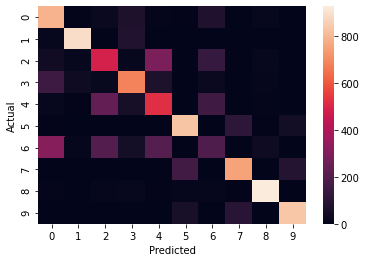

In [ ]:
sn.heatmap(confusion_matrix, annot=False)
plt.show()